In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap


mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })


colorMA90, colorSI06, colorG189E = "#E8735C", "#72C2A6", "#5482A7"


#### antibody choice ####
antibody = "CH65"
antigens = ["MA90", "SI06"]#, "G189E"]
L = 16
sequences_int = range(2**L)


#### selection model choice ####
#model = 'strong'
model = 'moderate'
#model = 'weak'
################################

if model == 'moderate':
    N = 1000
    gamma = 1.0
elif model == 'weak':
    N = 20
    gamma = 0.5

Nbootstrap = 10


# define some functions
def mutation(s, ii, L):
    """ Return the sequence (in int format) with base s,
        with a somatic mutation at pos ii """
    return s | 2**(L-1-ii)

def nb_mutation(s):
    """ Number of mutations in variant s """
    return bin(s).count("1")

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]

def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


#can add a constraint to pass thru intermediate here
# example
is_intermediate = False
INTERMEDIATE = int('0000001010100000', 2)
nb_mut_int = nb_mutation(INTERMEDIATE)
force_intermediate = dok_matrix((2**L, 2**L), dtype=np.float64)
for mut in range(L):
    t = mutation(INTERMEDIATE, mut, L)
    force_intermediate[INTERMEDIATE, t] = 1
    

# define data and image folder
data = ""
img = ""
##############################


# read dataframe
df = pd.read_csv(f"../../Kd_Inference/results_CH65/Kd_processed/20220603_CH65_QCfilt_REPfilt.csv", dtype={"geno":"str"})
df = df.rename(columns={"MA90_mean": "MA90_log10Kd", "SI06_mean": "SI06_log10Kd", "G189E_mean": "G189E_log10Kd",
                        "MA90_sem": "MA90_stelog10Kd", "SI06_sem": "SI06_stelog10Kd", "G189E_sem": "G189E_stelog10Kd"})

# convert genotypes to integers and sort accordingly    
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()

for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
      
# get average Kd for mixed scenarios    
df['mixed_log10Kd'] = df[[f"{a}_log10Kd" for a in antigens]].mean(axis=1)



import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600


In [2]:
proba_from_file = defaultdict(list)
with open(f'../../Pathway_Inference/unconstrained/likelihoods_'+antibody+'_'+model+'.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    for row in proba_reader:
        key = tuple(row[:L])
        value = [float(x) for x in row[L:]]
        proba_from_file[key] = value
    readfile.close()

num_random_contexts = 1000
proba_random_from_file = np.zeros((num_random_contexts,Nbootstrap))
contexts_random_from_file = []
with open(f'../../Pathway_Inference/unconstrained/likelihoods_'+antibody+'_'+model+'_random.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    i = 0
    for row in proba_reader:
        key = tuple(row[:L])
        contexts_random_from_file.append(key)
        value = [float(x) for x in row[L:]]   
        proba_random_from_file[i] = value
        i += 1
    readfile.close()

('MA90', 'SI06')
('SI06', 'MA90')
(105, 80)


/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/3536434709.py:104: RuntimeWarning: invalid value encountered in log
  max_loglik = np.nanmax(np.log(likelihoods))
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/3536434709.py:104: RuntimeWarning: All-NaN slice encountered
  max_loglik = np.nanmax(np.log(likelihoods))
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/3536434709.py:105: RuntimeWarning: invalid value encountered in log
  min_loglik = np.nanmin(np.log(likelihoods))
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/3536434709.py:105: RuntimeWarning: All-NaN slice encountered
  min_loglik = np.nanmin(np.log(likelihoods))
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/3536434709.py:137: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


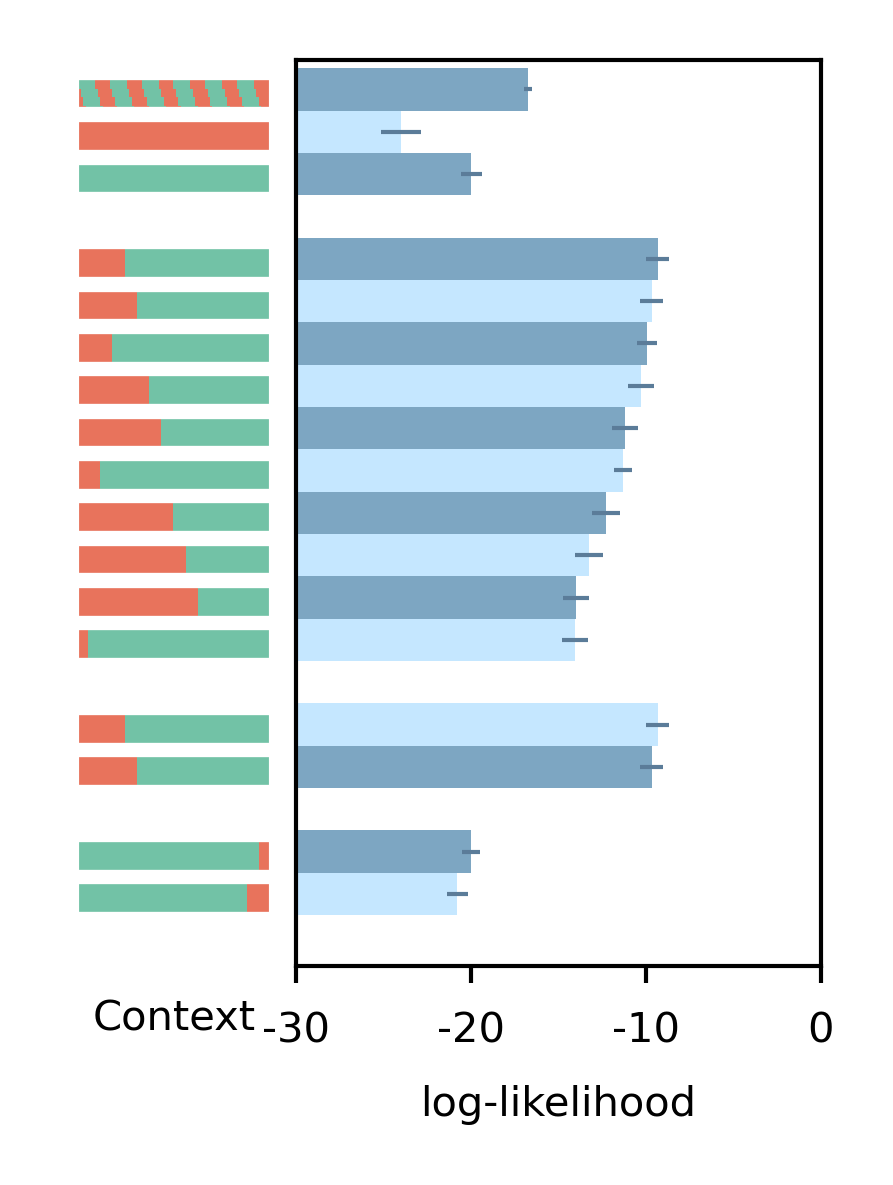

In [3]:
# plot for moderate/weak selection
if model == 'strong':
    sys.exit()
    
# select contexts we want to plot at the top
if antibody == 'CH65':
    constant_scenarios = [tuple(["random"]*L),
                      tuple(["MA90"]*L),tuple(["SI06"]*L)#, tuple(["G189E"]*L)
                         ]

    
# sort other scenarios by likelihood
scenarios_sorted = [k for k, v in sorted(proba_from_file.items(),
                                         key=lambda item: -np.log(np.mean([
                                             a for a in item[1] if a > 1e-80])))
                    if set(k) == set(antigens) and not all([l == k[0] for l in k])]
scenarios_sorted_ctxt = {}
# select the best scenarios for all orderings
for ags in itertools.permutations(antigens):
    print(ags)
    valid_scenarios = [(k, v) for k, v in proba_from_file.items() if tuple(dict.fromkeys(k)) == ags]
    valid_scenarios = [k for k, v in sorted(valid_scenarios, key=lambda item:
                                            -np.log(np.mean(
                                                [a for a in item[1] if a > 1e-80])))
                                                if not all([l == k[0] for l in k])]
    scenarios_sorted_ctxt[ags] = valid_scenarios


if antibody == 'CH65':
    keys = constant_scenarios
    keys += [tuple(["white"]*L)] #white is a very ugly trick to jump a line
    keys += scenarios_sorted[:10]
    keys += [tuple(["white"]*L)] #white is a very ugly trick to jump a line
    for ags in itertools.permutations(antigens):
        keys += scenarios_sorted_ctxt[ags][:2]
        keys += [tuple(["white"]*L)] #white is a very ugly trick to jump a line
    keys = tuple(keys[::-1])
        
likelihoods, err_likelihoods = [], []
for k in keys:
    if "white" in k:
        likelihoods += [np.nan]
        err_likelihoods += [np.nan]
    elif "random" in k:
        likelihoods += [np.mean(np.log(np.mean(proba_random_from_file,axis=1)),axis=0)]
        err_likelihoods += [np.std(np.std(proba_random_from_file,axis=1,ddof=1)/np.mean(proba_random_from_file,axis=1),ddof=1) ]

    elif np.mean(proba_from_file[k]) > 0:
        likelihoods += [np.log(np.mean([a for a in proba_from_file[k]]))]
        err_likelihoods += [np.std([a for a in proba_from_file[k]],ddof=1)/np.mean([a for a in proba_from_file[k]])]

likelihoods = np.array(likelihoods)
err_likelihoods = np.array(err_likelihoods)
        
val = np.zeros((5*L, 5*len(keys)))
for ii, key in enumerate(keys):
    for jj, a in enumerate(key):
        val[5*jj:5*(jj+1), 5*ii:5*(ii+1)] = {"MA90":1, "SI06":2, "G189E": 3, "":0, "white":-1, "random":-2}[a]
#these are listed in increasing order to match the colors list below
        
if antibody == 'CH65':        
    fig = plt.figure(constrained_layout=True, figsize=(1.6,2))
    gs = fig.add_gridspec(1,7)
    ax0 = fig.add_subplot(gs[0,0:2])
    ax = fig.add_subplot(gs[0,2:], sharey=ax0)
        

# Turn off tick labels
ax0.set_yticks([])
ax0.set_xticks([])
ax0.spines['top'].set_color('white')
ax0.spines['bottom'].set_color('white')
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

pal = sns.color_palette()

# order random/mixed - white - nothing - MA90 - S106 - G189E
colors = [colorMA90, 'white', 'xkcd:light grey', colorMA90,  colorSI06,  colorG189E]
cmap = mpl.colors.ListedColormap(colors)
ax0.imshow(val.transpose(), interpolation='none', vmin=-2, vmax=3, cmap=cmap)

if antibody == "CH65":
    hashes = np.arange(0, val.shape[0]*val.shape[1]).reshape(val.shape).transpose()%13
    hashes1 =  hashes < 7
    print(hashes.shape)
    #hashes2 = (hashes >= 6)
    # add hash only in the "random" or "mixed" setup
    ax0.imshow((val.transpose() == -2)*hashes1, 
               interpolation='none', cmap=mpl.colors.ListedColormap(["#FFFFFF00", colorSI06]))
    #ax0.imshow((val.transpose() == -2)*hashes2, 
    #           interpolation='none', cmap=mpl.colors.ListedColormap(["#FFFFFF00", colorG189E]))

ax0.set_aspect('auto')
for ii in range((val.shape[1]//5+1)):
    #ax0.axhline(5*ii-1, color="white", alpha=1, lw=1)
    ax0.plot([0,5*L],[5*ii-.9,5*ii-.9],color="white", alpha=1, lw=1)
    ax0.plot([0,5*L],[5*ii-.1,5*ii-.1],color="white", alpha=1, lw=1)

ax0.set_ylim(-1, val.shape[1]+1)
ax0.set_xlim([0,5*L])
ax0.set_xlabel("Context", fontsize=5)

max_loglik = np.nanmax(np.log(likelihoods))
min_loglik = np.nanmin(np.log(likelihoods))
value_displayed = likelihoods #(-min_loglik + np.log(likelihoods))/(max_loglik - min_loglik)*0.8 + 0.1
err_values = np.nan_to_num(err_likelihoods, 0)#/(max_loglik - min_loglik)*0.8, 0)

#print(err_values)

ax.barh(width=value_displayed+40,
           y=np.arange(2.5, 5*len(likelihoods), 5), height=5., left=-40,
        color=["#7da6c2", "#c5e7ff"]*(len(likelihoods)//2))
#ax.invert_xaxis()
ax.errorbar(x=value_displayed,
           y=np.arange(2.5, 5*len(likelihoods), 5),
            xerr=err_values, color="k", markersize=10, linestyle='', elinewidth=0.5, ecolor="#5b7c99")

ax.set_xlabel("log-likelihood", fontsize=5)
#ax.set_xticklabels([])
ax.set_ylim(-1, val.shape[1]+1)

if antibody == "9114" and model == 'moderate':
    ax.set_xlim(-40,-10)
    ax.set_xticks([-40,-30,-20,-10])
    ax.set_xticklabels([])
elif antibody == "9114" and model == 'weak' or model == 'weak2':
    ax.set_xlim(-30,0)
    ax.set_xticks([-30,-20,-10,0])
    ax.set_xticklabels([-40,-30,-20,-10])

elif antibody == "CH65":
    ax.set_xlim(-30,0)
    ax.set_xticks([-30,-20,-10,0])
    ax.set_xticklabels([-30,-20,-10,0],fontsize=5)

plt.subplots_adjust(wspace=0.3)
   
plt.savefig(f"unconstrained_images/context_likelihood_{antibody}_{model}_complete.pdf",dpi=1200,bbox_inches='tight')

plt.show()

In [4]:
#find the best and median random contexts
random_means = np.mean(proba_random_from_file,axis=1)
random_means_sorted = sorted(range(len(random_means)),key = lambda x: random_means[x])
median_random_index = random_means_sorted[int(len(random_means)/2)+2] 
print(median_random_index) #np.log(proba_random[median_random_index]))
median_random = contexts_random_from_file[median_random_index]
print(median_random,np.log(random_means[median_random_index]))


## define antigen context
if antibody == "CH65":
    antigen_contexts = { "optimal": ["MA90"]*4 + ["SI06"]*12,
                            "MA90alone": ["MA90"]*16,  
                         "SI06alone": ["SI06"]*16,
                         "mixed": ["mixed"]*16,
                           "random_median": median_random}
    
## load pmut
import pickle
with open(f"../../Pathway_Inference/unconstrained/pmut_normed.pkl", 'rb') as f:
    pmut_normed = pickle.load(f)
with open(f"../../Pathway_Inference/unconstrained/pmut_unnormed.pkl", 'rb') as f:
    pmut_unnormed = pickle.load(f)

815
('SI06', 'MA90', 'MA90', 'SI06', 'SI06', 'SI06', 'SI06', 'MA90', 'MA90', 'MA90', 'SI06', 'MA90', 'MA90', 'MA90', 'SI06', 'SI06') -16.483199449165568


optimal


  0%|          | 0/65536 [00:00<?, ?it/s]

0.0 764.800113633222
3484


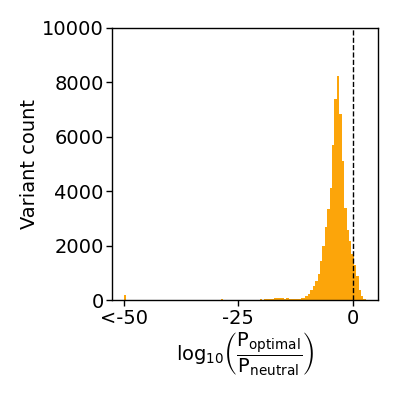

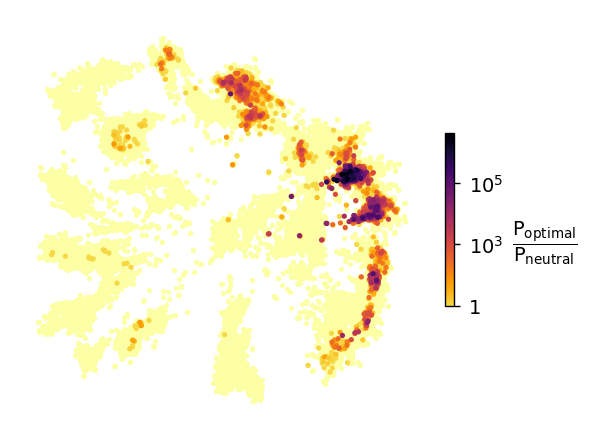

In [5]:
#### Plot probabilty of each variant in optimal context ####
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors
for context in ["optimal"]:
    print(context)
    antigen_context = antigen_contexts[context]
    ## Compute the probability of belonging to the path for each variant
    # if strong selection, use non-normalized, otherwise normalized
    if model == 'strong':
        A = {0: pmut_unnormed[antigen_context[0]]**0}
        B = {0: pmut_unnormed[antigen_context[0]]**0}
        for ii in range(1, L+1):
            A[ii] = A[ii-1]@pmut_unnormed[antigen_context[ii-1]]
            B[ii] = pmut_unnormed[antigen_context[ii-1]]@B[ii-1]
    else:
        A = {0: pmut_normed[antigen_context[0]]**0}
        B = {0: pmut_normed[antigen_context[0]]**0}
        for ii in range(1, L+1):
            A[ii] = A[ii-1]@pmut_normed[antigen_context[ii-1]]
            B[ii] = pmut_normed[antigen_context[ii-1]]@B[ii-1]
        

    proba = np.zeros(2**L)
    norm = defaultdict(int)
    for v in tqdm(sequences_int):
        if v != 0 and v != 2**L - 1:
            n = nb_mutation(v)
            proba[v] = (A[n])[0, v] * B[L - n][v, 2**L-1]
            norm[n] += 1
    for v in sequences_int:
        if model == 'strong':
            # normalize explicitly
            proba[v] = proba[v] * norm[nb_mutation(v)] /math.factorial(L)
        else:
            proba[v] = proba[v] * norm[nb_mutation(v)]
    proba[0] = 1
    proba[2**L-1] = 1
    
    #df["proba_path"] = proba 

    mpl.rcParams['figure.dpi'] = 200

    print(np.nanmin(proba),np.nanmax(proba))

    indices = np.where(proba > 0.0)[0]

    if model != 'strong':
        probas_for_plot = np.log10(proba[indices])
    too_low = np.where(probas_for_plot < -50)[0]
    probas_for_plot[too_low] = -50
    
    print(len(np.where(probas_for_plot > 0)[0]))
                         
    fig,ax = plt.subplots(figsize=(2,2))
    ax.tick_params(pad=1)
    plt.hist(probas_for_plot,bins=100,color=cm.inferno_r(0.2))
    #plt.yscale('log')
    plt.plot([0,0],[0,10000],'k--',linewidth=0.5)
    plt.ylim([0,10000])
    #plt.xlim(-102,0)
    plt.xticks([-50,-25,0,],['<-50','-25','0'])
    #plt.yticks([0,2000,4000,6000],['0','2000','4000','6000'])
    plt.xlabel(r'$\log_{10}\left(\dfrac{P_{optimal}}{P_{neutral}}\right)$',labelpad=1)
    plt.ylabel('Variant count',labelpad=1)
    plt.tight_layout()
    plt.savefig(f'unconstrained_images/variantdist_'+antibody+'_'+context+'_'+model+'.pdf')
    plt.show()
    #df

    df_fdl = pd.read_csv(f"../../CH65_browser/data/CH65.csv", dtype={"variant":"str"})
    df_fdl["variant_int"] = df_fdl.variant.apply(lambda x: int(x, 2))
    df_fdl = df_fdl.set_index("variant_int").reindex(range(0, 2**L)).reset_index()

    df_fdl["path_prob"] = proba

    df_fdl = df_fdl.sort_values(by=["path_prob"])

    minval = 1.0
    cmap = plt.get_cmap('inferno_r')
    new_cmap = truncate_colormap(cmap, 0.1,1)

    plt.figure(figsize=(3,3)) #plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})
    ax = plt.subplot(111)
    ax.scatter(x=-1.0*df_fdl.fdl_x, y=-1.0*df_fdl.fdl_y,
           s=.8, color =cmap(0.0), alpha=1)
    sc = ax.scatter(x=-1.0*df_fdl.loc[df_fdl['path_prob'] > minval,'fdl_x'], y=-1.0*df_fdl.loc[df_fdl['path_prob'] > minval,'fdl_y'],
           s=.8, c=np.log(df_fdl.loc[df_fdl['path_prob'] > minval,'path_prob']),
           cmap=new_cmap,vmin=minval,alpha=1)
    cbar = plt.colorbar(sc,fraction=0.02,ticks=[1,3,5])
    cbar.ax.set_yticklabels(['1','$10^3$','$10^5$'])
    cbar.ax.set_ylabel(r'$\dfrac{P_{optimal}}{P_{neutral}}$',rotation='horizontal',labelpad=15)
    #plt.clim(-4,4)
    ax.set_aspect('equal')


    #ax.get_legend().remove()
    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(f'unconstrained_images/landscape_paths_'+antibody+'_'+context+'_'+model+'.png',dpi=600)
    plt.show()
    
#     sys.exit()
    
    
    

In [6]:
# compute probability for I-2

proba[INTERMEDIATE] / sum([proba[x] for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1')])

0.0029089690036269455

/Users/angelaphillips/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_42829/2129586345.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.axvline(np.median([np.log10(proba[x]) for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1')


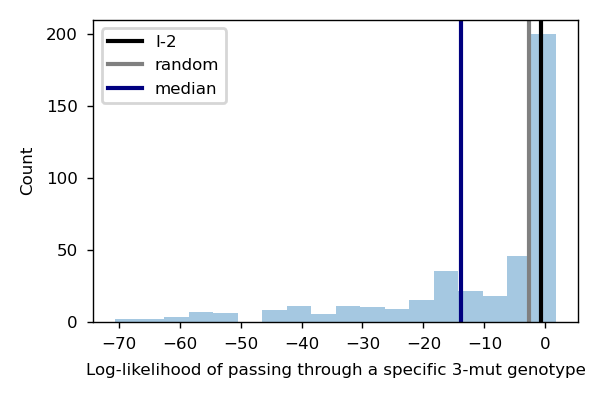

In [7]:
fig,ax = plt.subplots(figsize=(3,2))
sns.distplot([np.log10(proba[x]) for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1') 
              and not pd.isna(proba[x]) and proba[x] > 0], kde=False)
plt.axvline(np.log10(np.log10(proba[INTERMEDIATE])), c="k", label="I-2")
plt.axvline(np.log10((1/560)), c="gray", label="random")
plt.axvline(np.median([np.log10(proba[x]) for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1') 
              and not pd.isna(proba[x])]), c="navy", label="median")
plt.xlabel("Log-likelihood of passing through a specific 3-mut genotype",fontsize=6)
plt.ylabel("Count",fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig(f'unconstrained_images/3mut_prob.png',dpi=600)
plt.show()

In [8]:
proba[INTERMEDIATE]

1.6290226420310885

In [9]:
max([(proba[x],x) for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1') 
              and not pd.isna(proba[x]) and proba[x] > 0])

(54.84051040078311, 8480)

In [10]:
bin(8480), bin(INTERMEDIATE)

('0b10000100100000', '0b1010100000')

In [11]:
1/(len([proba[x] for x in sequences_int if bin(x).count('1') == bin(INTERMEDIATE).count('1') ])), 1/560

(0.0017857142857142857, 0.0017857142857142857)

In [12]:
with open(f"../../Pathway_Inference/unconstrained/best_paths.pkl", 'rb') as f:
    best_paths = pickle.load(f)
    num_best_paths = len(best_paths[list(best_paths.keys())[0]])

In [13]:
# get Kds and delta Kds for CH65 best paths
num_to_use = 25

best_path_mean_Kds_MA90 = {}
best_path_mean_Kds_SI06 = {}
best_path_std_Kds_MA90 = {}
best_path_std_Kds_SI06 = {}

best_paths_Kds_MA90 = {}
best_paths_Kds_SI06 = {}
best_paths_err_Kds_MA90 = {}
best_paths_err_Kds_SI06 = {}


for ac in antigen_contexts:
    best_path_means_MA90 = np.empty((num_to_use,L+1),dtype=float)
    best_path_stderr_MA90 = np.empty((num_to_use,L+1),dtype=float)
    best_path_means_SI06 = np.empty((num_to_use,L+1),dtype=float)
    best_path_stderr_SI06 = np.empty((num_to_use,L+1),dtype=float)

    for i in range(num_to_use):
        best_path_means_MA90[i,:] = [df.loc[best_paths[ac][i,n]]["MA90_log10Kd"] for n in range(L+1)]
        best_path_stderr_MA90[i,:] = [df.loc[best_paths[ac][i,n]]["MA90_stelog10Kd"] for n in range(L+1)]
        best_path_means_SI06[i,:] = [df.loc[best_paths[ac][i,n]]["SI06_log10Kd"] for n in range(L+1)]
        best_path_stderr_SI06[i,:] = [df.loc[best_paths[ac][i,n]]["SI06_stelog10Kd"] for n in range(L+1)]
    
    #best_paths_geno[ac] = best_path_geno
    best_paths_Kds_MA90[ac] = best_path_means_MA90
    best_paths_err_Kds_MA90[ac] = best_path_stderr_MA90
    best_paths_Kds_SI06[ac] = best_path_means_SI06
    best_paths_err_Kds_SI06[ac] = best_path_stderr_SI06
    
    best_path_mean_Kds_MA90[ac] = np.nanmean(best_path_means_MA90,axis=0)
    best_path_mean_Kds_SI06[ac] = np.nanmean(best_path_means_SI06,axis=0)
    
    best_path_std_Kds_MA90[ac] = np.std(best_path_means_MA90,axis=0)
    best_path_std_Kds_SI06[ac] = np.std(best_path_means_SI06,axis=0)

['MA90', 'MA90', 'MA90', 'MA90', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06']
['MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90']
['SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06']
['mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed']


TypeError: '<=' not supported between instances of 'int' and 'str'

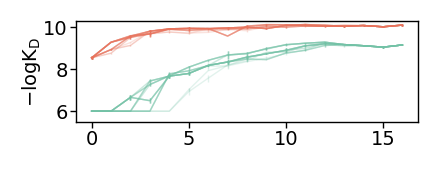

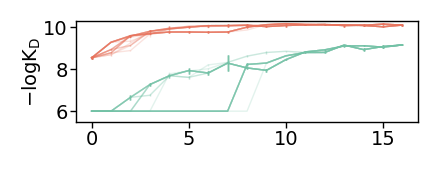

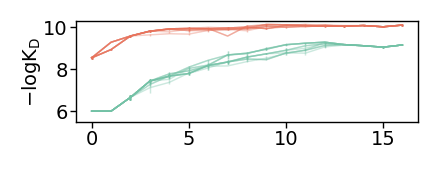

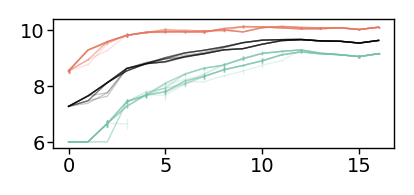

In [14]:
for context in antigen_contexts:
    print(antigen_contexts[context])
    fig,ax = plt.subplots(figsize=(2.2,0.85))
    ax.tick_params(pad=1)
    for i in range(num_best_paths):
        plt.errorbar(x=range(L+1),y=best_paths_Kds_SI06[context][i],yerr=best_paths_err_Kds_SI06[context][i],
                 color=colorSI06,alpha=0.2,linewidth=0.5)
        plt.errorbar(x=range(L+1),y=best_paths_Kds_MA90[context][i],yerr=best_paths_err_Kds_MA90[context][i],
                 color=colorMA90,alpha=0.2,linewidth=0.5)
        
        if context == "mixed":
            plt.errorbar(x=range(L+1),y=np.mean([best_paths_Kds_SI06[context][i],best_paths_Kds_MA90[context][i]],axis=0),
                color='k',alpha=0.2,linewidth=0.5)
            
    #plt.xlabel('Number of mutations')
    plt.ylabel(f"$-logK_D$",labelpad=0)
    #plt.xticks(np.arange(0,18,2),[str(x) for x in np.arange(0,18,2)])
    plt.yticks([6,8,10],['6','8','10'])
    plt.ylim([5.5,10.3])
    plt.tight_layout()
    plt.savefig('unconstrained_images/average_paths_'+antibody+'_'+context+'_'+model+'.pdf')

plt.show()

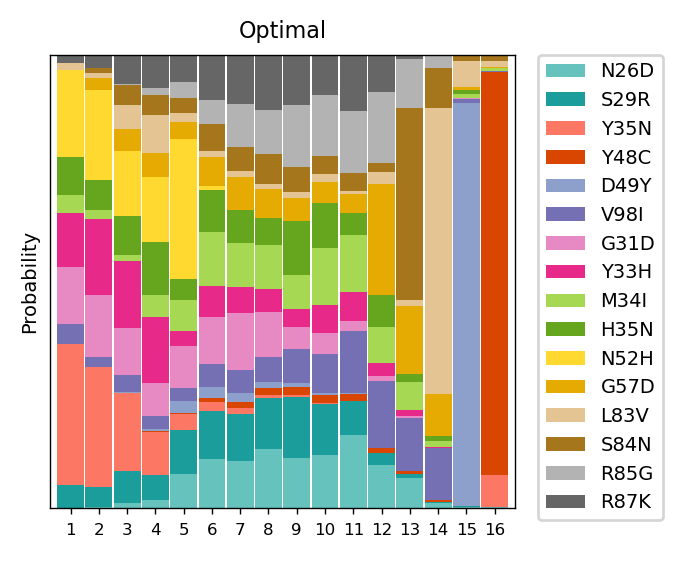

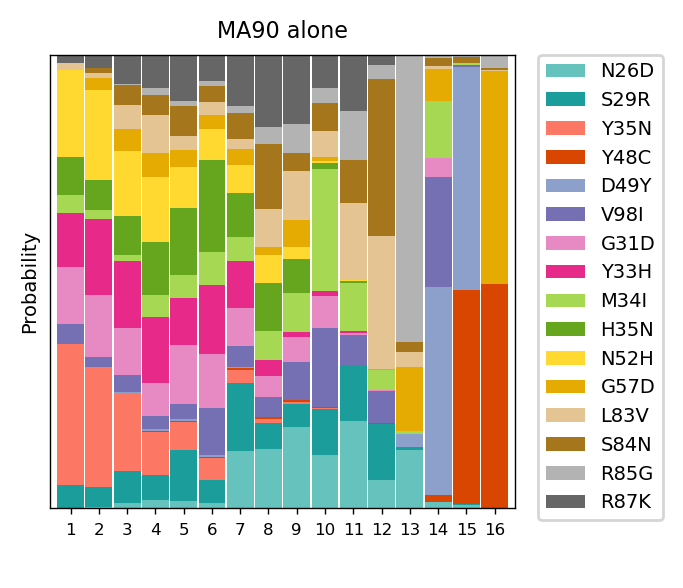

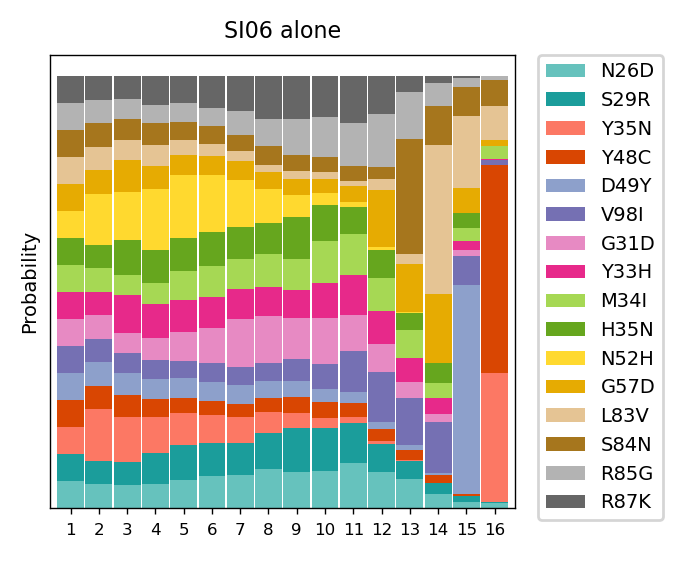

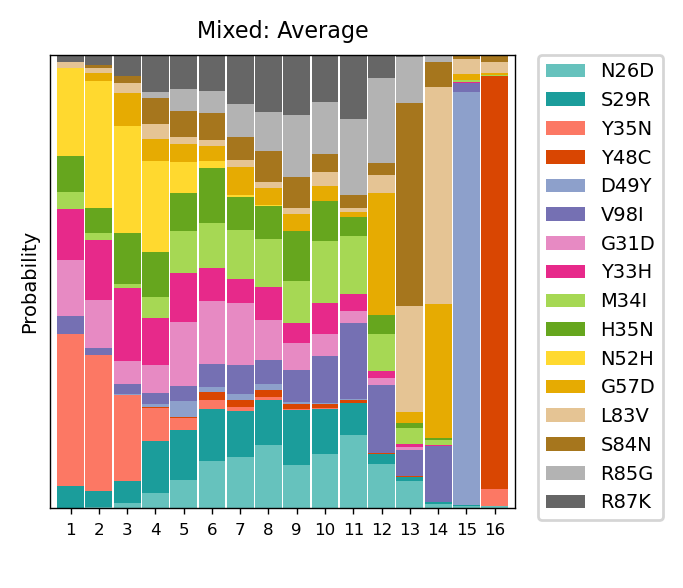

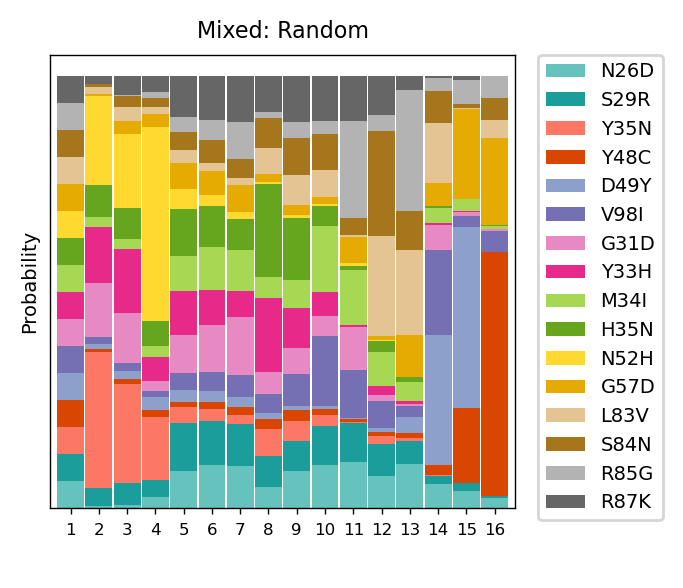

In [15]:
for context in antigen_contexts:
    if context=="MA90alone":
        title="MA90 alone"
    if context=="SI06alone":
        title="SI06 alone"
    if context=="mixed":
        title="Mixed: Average"
    if context=="optimal":
        title="Optimal"
    if context=="random_median":
        title="Mixed: Random"
    df_mutorder = pd.read_csv('../../Pathway_Inference/unconstrained/CH65_probability_%s_moderate.csv' % context,index_col='Mutation')
    dft = df_mutorder.transpose()
    dft.plot(kind='bar', stacked=True, width = 0.95,
         color = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", 
                  "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854",
                  "#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"],figsize=(3,3))
    plt.title('%s' % title, fontsize=8)
    plt.xlabel(' ')
    plt.ylabel('Probability')
    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
               labels=['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I',
                       'H35N','N52H','G57D','L83V','S84N','R85G','R87K'])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
               ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],fontsize=6,rotation=0)
    plt.savefig('unconstrained_images/%s_moderate_mutorder_uncon.pdf' % context,dpi=600,bbox_inches='tight')
    plt.show()